In [5]:
import torch
import os
import PATH
import copy
import utils
import numpy as np
from tqdm import tqdm
from models import reader
from models.popen import Auto_popen
from sklearn.metrics import r2_score
# import ipynb.analysis_for_MTL as A_MTL
from scipy import stats

In [6]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [7]:
os.getpid()

110549

# function

In [ ]:
POPEN  = Auto_popen(
    '/ssd/users/wergillius/Project/UTR_VAE/log/Backbone/RL_3_data/iter_by_iter/test_iter.ini')
POPEN.kfold_index = None
loader_set = {}
base_path = POPEN.split_like_paper.copy()
for subset in POPEN.cycle_set:
    POPEN.split_like_paper = [path.replace('cycle', subset) for path in base_path]
    loader_set[subset] = reader.get_dataloader(POPEN)

In [ ]:
POPEN  = Auto_popen(
    '/ssd/users/wergillius/Project/UTR_VAE/log/Backbone/RL_3_data/iter_by_iter/schedule_relay_lr.ini')
POPEN.kfold_index = None
loader_set = {}
base_path = POPEN.split_like_paper.copy()
for subset in POPEN.cycle_set:
    POPEN.split_like_paper = [path.replace('cycle', subset) for path in base_path]
    loader_set[subset] = reader.get_dataloader(POPEN)

In [ ]:
def reload_model(config_file, device, kfold_index):
    config_file = os.path.join("/ssd/users/wergillius/Project/UTR_VAE/", config_file)
    
    POPEN  = Auto_popen(config_file)
    if kfold_index is None:
        check_point = torch.load(POPEN.vae_pth_path, map_location=device)
    else:
        check_point = torch.load(
            POPEN.vae_pth_path.replace('.pth', '_cv%d.pth'%kfold_index),
            map_location=device)
        
    model = check_point['state_dict'].to(device)
    return model

def val_a_epoch(model, dataloader, device):
    y_true_ls = []
    y_pred_ls = []
    
    model.eval()
    with torch.no_grad():
        for X,Y in tqdm(dataloader):
            X = X.float().to(device)
            y_true_ls.append(Y.cpu().numpy())

            y_pred = model(X)
            y_pred_ls.append(y_pred.cpu().numpy())
    
    y_true_f = np.concatenate( y_true_ls).flatten()
    y_pred_f = np.concatenate( y_pred_ls).flatten()
    
    return y_true_f, y_pred_f

def kfold_load_data(config_file, device, kfold_index, label_uAUG=False ,expand_MAP=False):
    config_file = os.path.join("/ssd/users/wergillius/Project/UTR_VAE/", config_file)
    
    POPEN = Auto_popen(config_file)
    POPEN.kfold_index = kfold_index
    POPEN.shuffle = False
    if expand_MAP:
        if ('human' in POPEN.cycle_set) or ('SubHuman' in POPEN.cycle_set):
            POPEN.cycle_set = set(POPEN.cycle_set+['vleng','unmod1'])
    
    loader_set = {}
    base_path = copy.copy(POPEN.split_like_paper)
    base_csv = copy.copy(POPEN.csv_path)
    # for subset in POPEN.cycle_set:
    #     if base_path is not None:
    #         POPEN.split_like_paper = [path.replace('cycle', subset) for path in base_path]
    #     else:
    #         POPEN.csv_path = base_csv.replace('cycle', subset)
    #     loader_set[subset] = reader.get_dataloader(POPEN)
        
    for subset in POPEN.cycle_set:
        if (subset in ['unmod1', 'human', 'vleng', 'SubHuman','SubVleng']):
            datapopen = Auto_popen('/ssd/users/wergillius/Project/UTR_VAE/log/Backbone/RL_3_data/rl_train_val_10fold/schedule_lr.ini')
            datapopen.split_like_paper = [path.replace('cycle', subset) for path in base_path]
            datapopen.kfold_index = kfold_index
            datapopen.shuffle = False
            if label_uAUG:
                datapopen.aux_task_columns += ['with_uAUG']
            loader_set[subset] = reader.get_dataloader(datapopen)
            
        elif (subset in ['Andrev2015', 'muscle', 'pc3']):
            datapopen = Auto_popen('/ssd/users/wergillius/Project/UTR_VAE/log/Backbone/RL_celline/MDL_pretrain_relax/pretrain_relax.ini')
            datapopen.csv_path = base_csv.replace('cycle', subset)
            datapopen.kfold_index = kfold_index
            datapopen.shuffle = False
            if label_uAUG:
                datapopen.aux_task_columns += ['with_uAUG']
            loader_set[subset] = reader.get_dataloader(datapopen)
        
    return loader_set


def pipeline_for_RL_3_data(config_file, which_set=1, device='cpu'):
    
    device = torch.device('cuda:%s'%device) if type(device)==int else 'cpu'
    
    model = reload_model(config_file, device)
    
    r2_dict = {}
    for cycle in ['unmod1', 'human', 'vleng']:
        model.task = cycle # which works for normal RL_gru
        dataloader = loader_set[cycle][which_set]
        y_true_f, y_pred_f = val_a_epoch(model, dataloader, device)
        r2_dict[cycle] = A_MTL.compute_r2(y_true_f,y_pred_f) , r2_score(y_true_f,y_pred_f)
    
    del model
    
    return r2_dict

In [ ]:
def pipeline_cell_line(config_file, which_set=2, device='cpu', kfold_index=None, expand_MAP=False, label_uAUG=False):
    
    device = torch.device('cuda:%s'%device) if type(device)==int else 'cpu'
    
    loader_set = kfold_load_data(config_file, device, kfold_index, label_uAUG=label_uAUG, expand_MAP=expand_MAP)
    
    # trained tasks from popen
    config_file = os.path.join("/ssd/users/wergillius/Project/UTR_VAE/", config_file)
    model = reload_model(config_file, device, kfold_index)
    popen = Auto_popen(config_file)
    trained_task = popen.cycle_set
    
    # iter tasks
    r2_dict = {}
    for cycle in list(loader_set.keys()):
        model.task = cycle # which works for normal RL_gru
        
        if expand_MAP:
            # use human tower to predict unmod1 or vleng
            if (cycle in ['vleng', 'unmod1']) and (model.task not in trained_task):
                model.task = 'human' if 'human'  in trained_task else 'SubHuman'
                
        dataloader = loader_set[cycle][which_set]
        y_true_f, y_pred_f = val_a_epoch(model, dataloader, device)
        r2_dict[cycle] = stats.spearmanr(y_true_f, y_pred_f)[0]
    
    del model
    
    return r2_dict

In [ ]:
def singletask_cell_line(config_file, which_set=2, device='cpu', kfold_index=None):
    
    device = torch.device('cuda:%s'%device) if type(device)==int else 'cpu'
    
    popen = Auto_popen("/ssd/users/wergillius/Project/UTR_VAE/"+config_file)
    popen.kfold_index = kfold_index
    dataloader = reader.get_dataloader(popen)[which_set]
    model = reload_model(config_file, device, kfold_index)
    
    
    y_true_f, y_pred_f = val_a_epoch(model, dataloader, device)
    r2 = stats.spearmanr(y_true_f, y_pred_f)[0]
    
    del model
    
    return r2

In [ ]:
def testset_result( json , model_name):
    """
    convert prediction result dict in test set to seaborn favourable dataset
    
    Args:
        json : [dict]  , list of dict { 'task' : values}
        model_name : the model used to predict
    Return:
        df
    """
    tiddy_data = np.concatenate([np.stack(dic.items()) for dic in json])
    df = pd.DataFrame(tiddy_data,columns=['task','sp_r'])
    df['sp_r'] =df.sp_r.astype(float).apply(round, args=(3,))
    df['model'] = model_name
    df['R2'] = df.sp_r.apply(lambda x: x**2)
    return df

# Fig 3 A

## multitask and transfer

In [9]:
from scipy import stats

In [158]:
celline_df.median(axis=0)

293T               0.525079
muscle             0.556454
pc3                0.569844
single_293T        0.560483
single_muscle      0.582419
single_pc3         0.630961
scratch_293T       0.624463
scratch_muscle     0.622901
scratch_pc3        0.674663
pretrain_293T      0.619527
pretrain_muscle    0.616819
pretrain_pc3       0.677995
dtype: float64

## tasks

In [489]:
tasks = ['Andrev2015', 'muscle', 'pc3']

In [490]:
celline_scratch = {task:[] for task in ['Andrev2015', 'muscle', 'pc3']}
for k in range(10):
    config_file = 'log/Backbone/RL_celline/adam_MTL_log_te/adam_logte.ini'
    dictt = pipeline_cell_line(config_file, which_set=2, device='cpu', kfold_index=k)
    for t, value in celline_scratch.items():
        value.append(dictt[t])

100%|██████████| 108/108 [00:01<00:00, 82.03it/s]


In [491]:
pretrain_relax = {task:[] for task in ['Andrev2015','muscle','pc3']}

for k in range(10):
    config_file = 'log/Backbone/RL_celline/MDL_pretrain_relax/pretrain_relax.ini'
    dictt = pipeline_cell_line(config_file, which_set=2, device='cpu', kfold_index=k)
    for t, value in pretrain_relax.items():
        value.append(dictt[t])

100%|██████████| 108/108 [00:01<00:00, 75.42it/s] 


In [ ]:
schedule_MTL = {task:[] for task in ['Andrev2015','muscle','pc3']}

for k in range(10):
    config_file = 'log/Backbone/RL_celline/schedule_MTL_log_te/schedule_MTL.ini'
    dictt = pipeline_cell_line(config_file, which_set=2, device='cpu', kfold_index=k)
    for t, value in schedule_MTL.items():
        value.append(dictt[t])

100%|██████████| 108/108 [00:01<00:00, 75.74it/s] 


In [493]:
Andrev_single = []
for k in range(10):
    r2 = singletask_cell_line('log/Backbone/RL_gru_3DS/Andrev_single_task/log_te_cv.ini', which_set=2, device='cpu', kfold_index=k)
    Andrev_single.append(r2)

100%|██████████| 123/123 [00:01<00:00, 68.60it/s] 


In [494]:
muscle_single = []
for k in range(10):
    r2 = singletask_cell_line('log/Backbone/RL_gru_3DS/muscle_single_task/log_te_cv.ini', which_set=2, device='cpu', kfold_index=k)
    muscle_single.append(r2)

100%|██████████| 10/10 [00:00<00:00, 13.18it/s]


In [495]:
pc3_single = []
for k in range(10):
    r2 = singletask_cell_line('log/Backbone/RL_gru_3DS/pc3_single_task/log_te_cv.ini', which_set=2, device='cpu', kfold_index=k)
    pc3_single.append(r2)

100%|██████████| 107/107 [00:01<00:00, 62.00it/s]


## RF baseline

```ini
[Andrev2015]
RF model 0: 0.4924657212605863 
RF model 1: 0.5281069064582427 
RF model 2: 0.530928668110778 
RF model 3: 0.5489315401113655 
RF model 4: 0.5304438965685636 
RF model 5: 0.5253012636835631 
RF model 6: 0.5248564256078839 
RF model 7: 0.5138097617207024 
RF model 8: 0.5224129072284471 
RF model 9: 0.519344227291114 

[muscle]
RF model 0: 0.547566411902818 
RF model 1: 0.6028934072347887 
RF model 2: 0.5466940278158777 
RF model 3: 0.5598195354385015 
RF model 4: 0.6988736149307381 
RF model 5: 0.5530874986059995 
RF model 6: 0.4436371888563208 
RF model 7: 0.5683980917196295 
RF model 8: 0.5165763446687439 
RF model 9: 0.6730851953879395 

[pc3]
RF model 0: 0.5822413059055946 
RF model 1: 0.5713791713338693 
RF model 2: 0.5736660317091482 
RF model 3: 0.5863706242688773 
RF model 4: 0.5626639113217776 
RF model 5: 0.5413885293348174 
RF model 6: 0.5476142108387254 
RF model 7: 0.5736922150042232 
RF model 8: 0.5683095375450803 
RF model 9: 0.5644011672625084 
```

Andrev2015 = [0.4924657212605863, 
                0.5281069064582427,
                0.530928668110778, 
                0.5489315401113655, 
                0.5304438965685636, 
                0.5253012636835631, 
                0.5248564256078839, 
                0.5138097617207024, 
                0.5224129072284471, 
                0.519344227291114] 

muscle = [0.547566411902818, 
            0.6028934072347887, 
            0.5466940278158777, 
            0.5598195354385015, 
            0.6988736149307381, 
            0.5530874986059995, 
            0.4436371888563208, 
            0.5683980917196295, 
            0.5165763446687439, 
            0.6730851953879395]

pc3 = [0.5822413059055946, 
        0.5713791713338693, 
        0.5736660317091482, 
        0.5863706242688773, 
        0.5626639113217776, 
        0.5413885293348174, 
        0.5476142108387254, 
        0.5736922150042232, 
        0.5683095375450803, 
        0.5644011672625084]

In [497]:
Andrev2015 = [0.4924657212605863, 0.5281069064582427, 0.530928668110778, 0.5489315401113655, 0.5304438965685636, 0.5253012636835631, 0.5248564256078839, 0.5138097617207024, 0.5224129072284471, 0.519344227291114]

muscle = [0.547566411902818, 0.6028934072347887, 0.5466940278158777, 0.5598195354385015, 0.6988736149307381, 0.5530874986059995, 0.4436371888563208, 0.5683980917196295, 0.5165763446687439, 0.6730851953879395]

pc3 = [0.5822413059055946, 0.5713791713338693, 0.5736660317091482, 0.5863706242688773, 0.5626639113217776, 0.5413885293348174, 0.5476142108387254, 0.5736922150042232, 0.5683095375450803, 0.5644011672625084]

In [498]:
cellline_df = pd.DataFrame({'Andrev2015':Andrev2015, 'muscle':muscle, 'pc3':pc3})

In [499]:
pretrain = pd.DataFrame(pretrain_relax)
pretrain.columns = ['pretrain_'+col for col in pretrain.columns]

scratch = pd.DataFrame(schedule_MTL)
scratch.columns = ['scratch_'+col for col in scratch.columns]

In [500]:
pc3_single

[0.6261146046755312,
 0.6455717780336084,
 0.6280021502604668,
 0.6191832672515893,
 0.5994788348291581,
 0.5443297151949065,
 0.6405177399485841,
 0.6409295086575133,
 0.6649200010595442,
 0.6339195429871567]

In [501]:
muscle_single

[0.5910674042240102,
 0.5624750415862844,
 0.5545300178171422,
 0.5605096204965402,
 0.6321884581899986,
 0.566819108341178,
 0.5840877286226221,
 0.5896193819723788,
 0.6089749599833922,
 0.5807506797405655]

In [502]:
single = pd.DataFrame({'Andrev2015': Andrev_single , 'muscle': muscle_single , 'pc3': pc3_single})
single.columns = ['single_'+col for col in single.columns]

In [503]:
celline_df = pd.concat([cellline_df,single, scratch, pretrain], axis=1)

In [505]:
celline_df.to_csv('FIG3_3cellline_permformance.csv', index=False)

## plot

In [12]:
celline_df = pd.read_csv('FIG3_3cellline_permformance.csv')

In [13]:
A_col =[col for col in celline_df.columns if 'Andrev2015' in col]

In [63]:
celline_df.rename(dict(zip(A_col, [x.replace('Andrev2015','293T') for x in A_col])), axis=1, inplace=True)

In [7]:
model_dict = {"":"RF", "single":"single-task", "scratch":"MTtrans 3R", "pretrain":"3M init"}
all_df = pd.DataFrame([])
for col in celline_df.columns:
    tmp_df = celline_df[[col]].rename({col:'spr'}, axis=1)
    model, task = col.split("_") if len(col.split("_")) > 1 else ('', col.split("_")[0])
    tmp_df['task'] = task
    tmp_df['model'] = model_dict[model]
    
    all_df = all_df.append(tmp_df)

In [75]:
all_df.to_csv('FIG3_3cellline_permformance_sns.csv', index=False)

In [14]:
all_df= pd.read_csv('FIG3_3cellline_permformance_sns.csv')

In [154]:
import seaborn as sns
sns.set_theme(style='ticks',palette="pastel",font_scale=1.4)
plt.rcParams['figure.dpi'] = 600

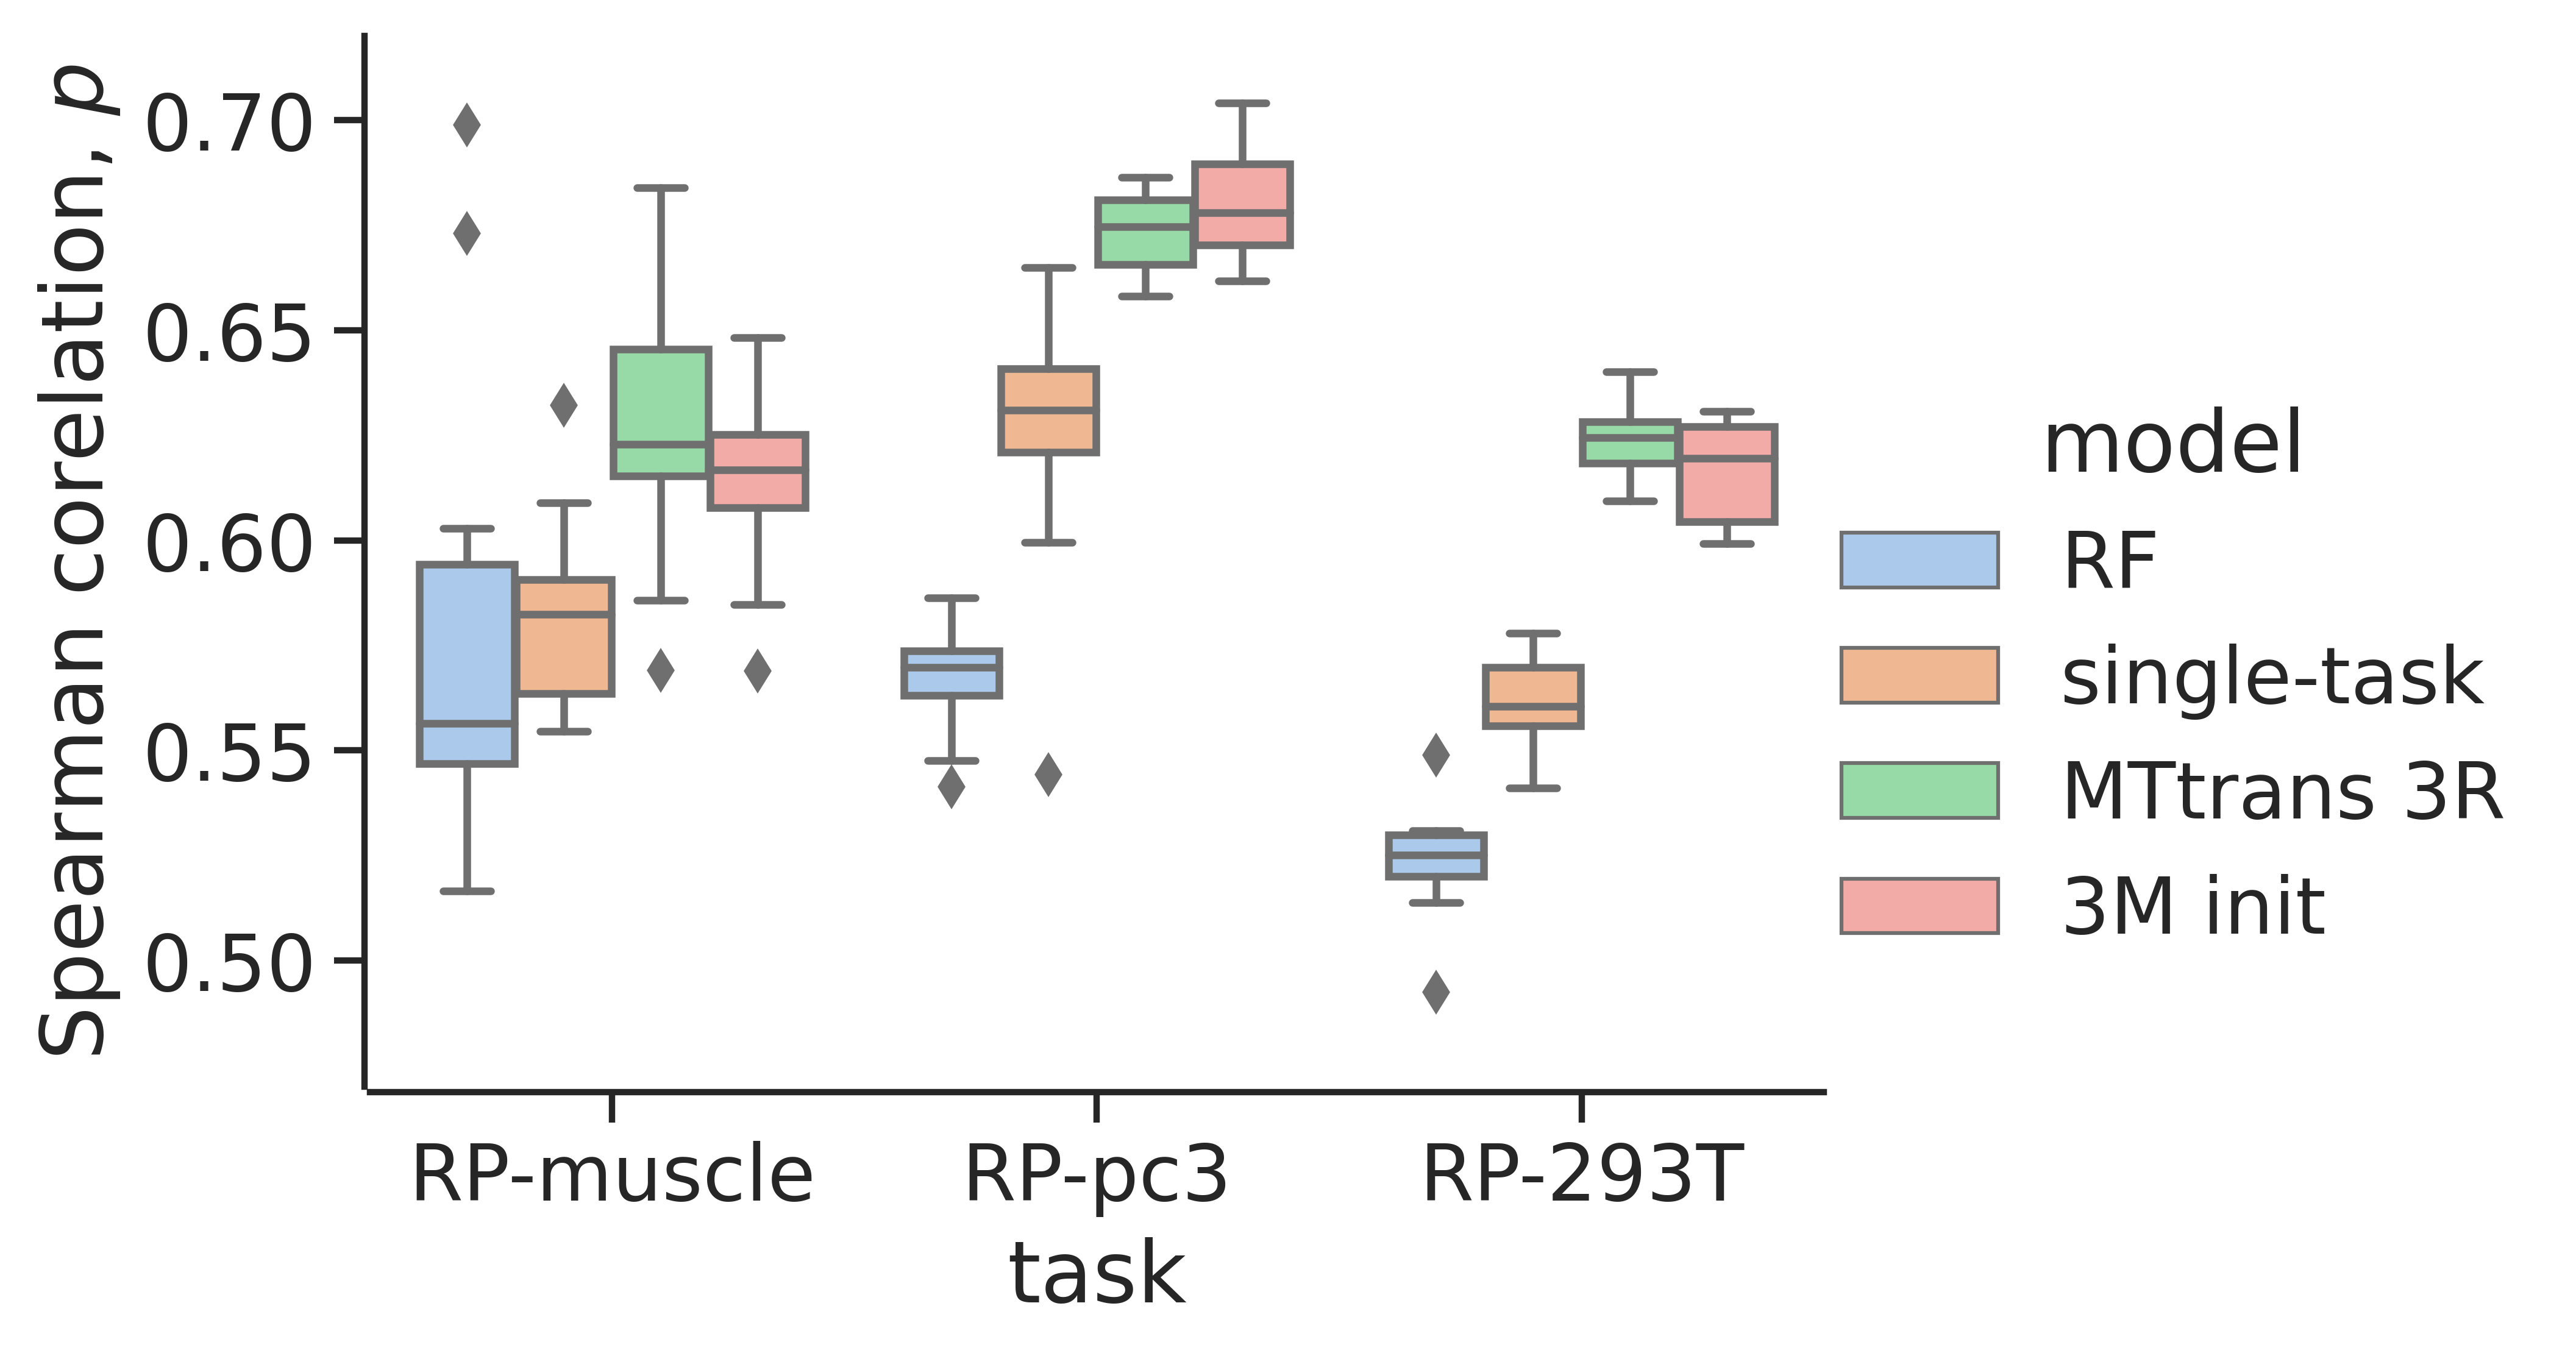

In [157]:
g=sns.catplot(data=all_df, x='task' ,y ='spr', hue='model', 
            order=['muscle', 'pc3', '293T'], kind='box', aspect=1.4, height=4)

sns.despine(trim=False, offset=1)
plt.ylim(0.47,0.72)
plt.ylabel(r'Spearman corelation, $p$')
plt.xticks([0,1,2],['RP-muscle','RP-pc3','RP-293T']);

# plt.legend(bbox_to_anchor=(1,0.5))

In [43]:
best_p_df.query('task == "Andrev2015"').sp_r.values

array([0.648, 0.644, 0.633])

In [44]:
best_p_df.query('task == "pc3"').sp_r.values

array([0.699, 0.676, 0.688])

In [45]:
sns.set_theme(style='ticks', palette="pastel", font_scale=1.5)

In [46]:
tasks = ['muscle', 'Andrev2015', 'pc3']

Text(0, 0.5, 'Spearman corelation, $p$')

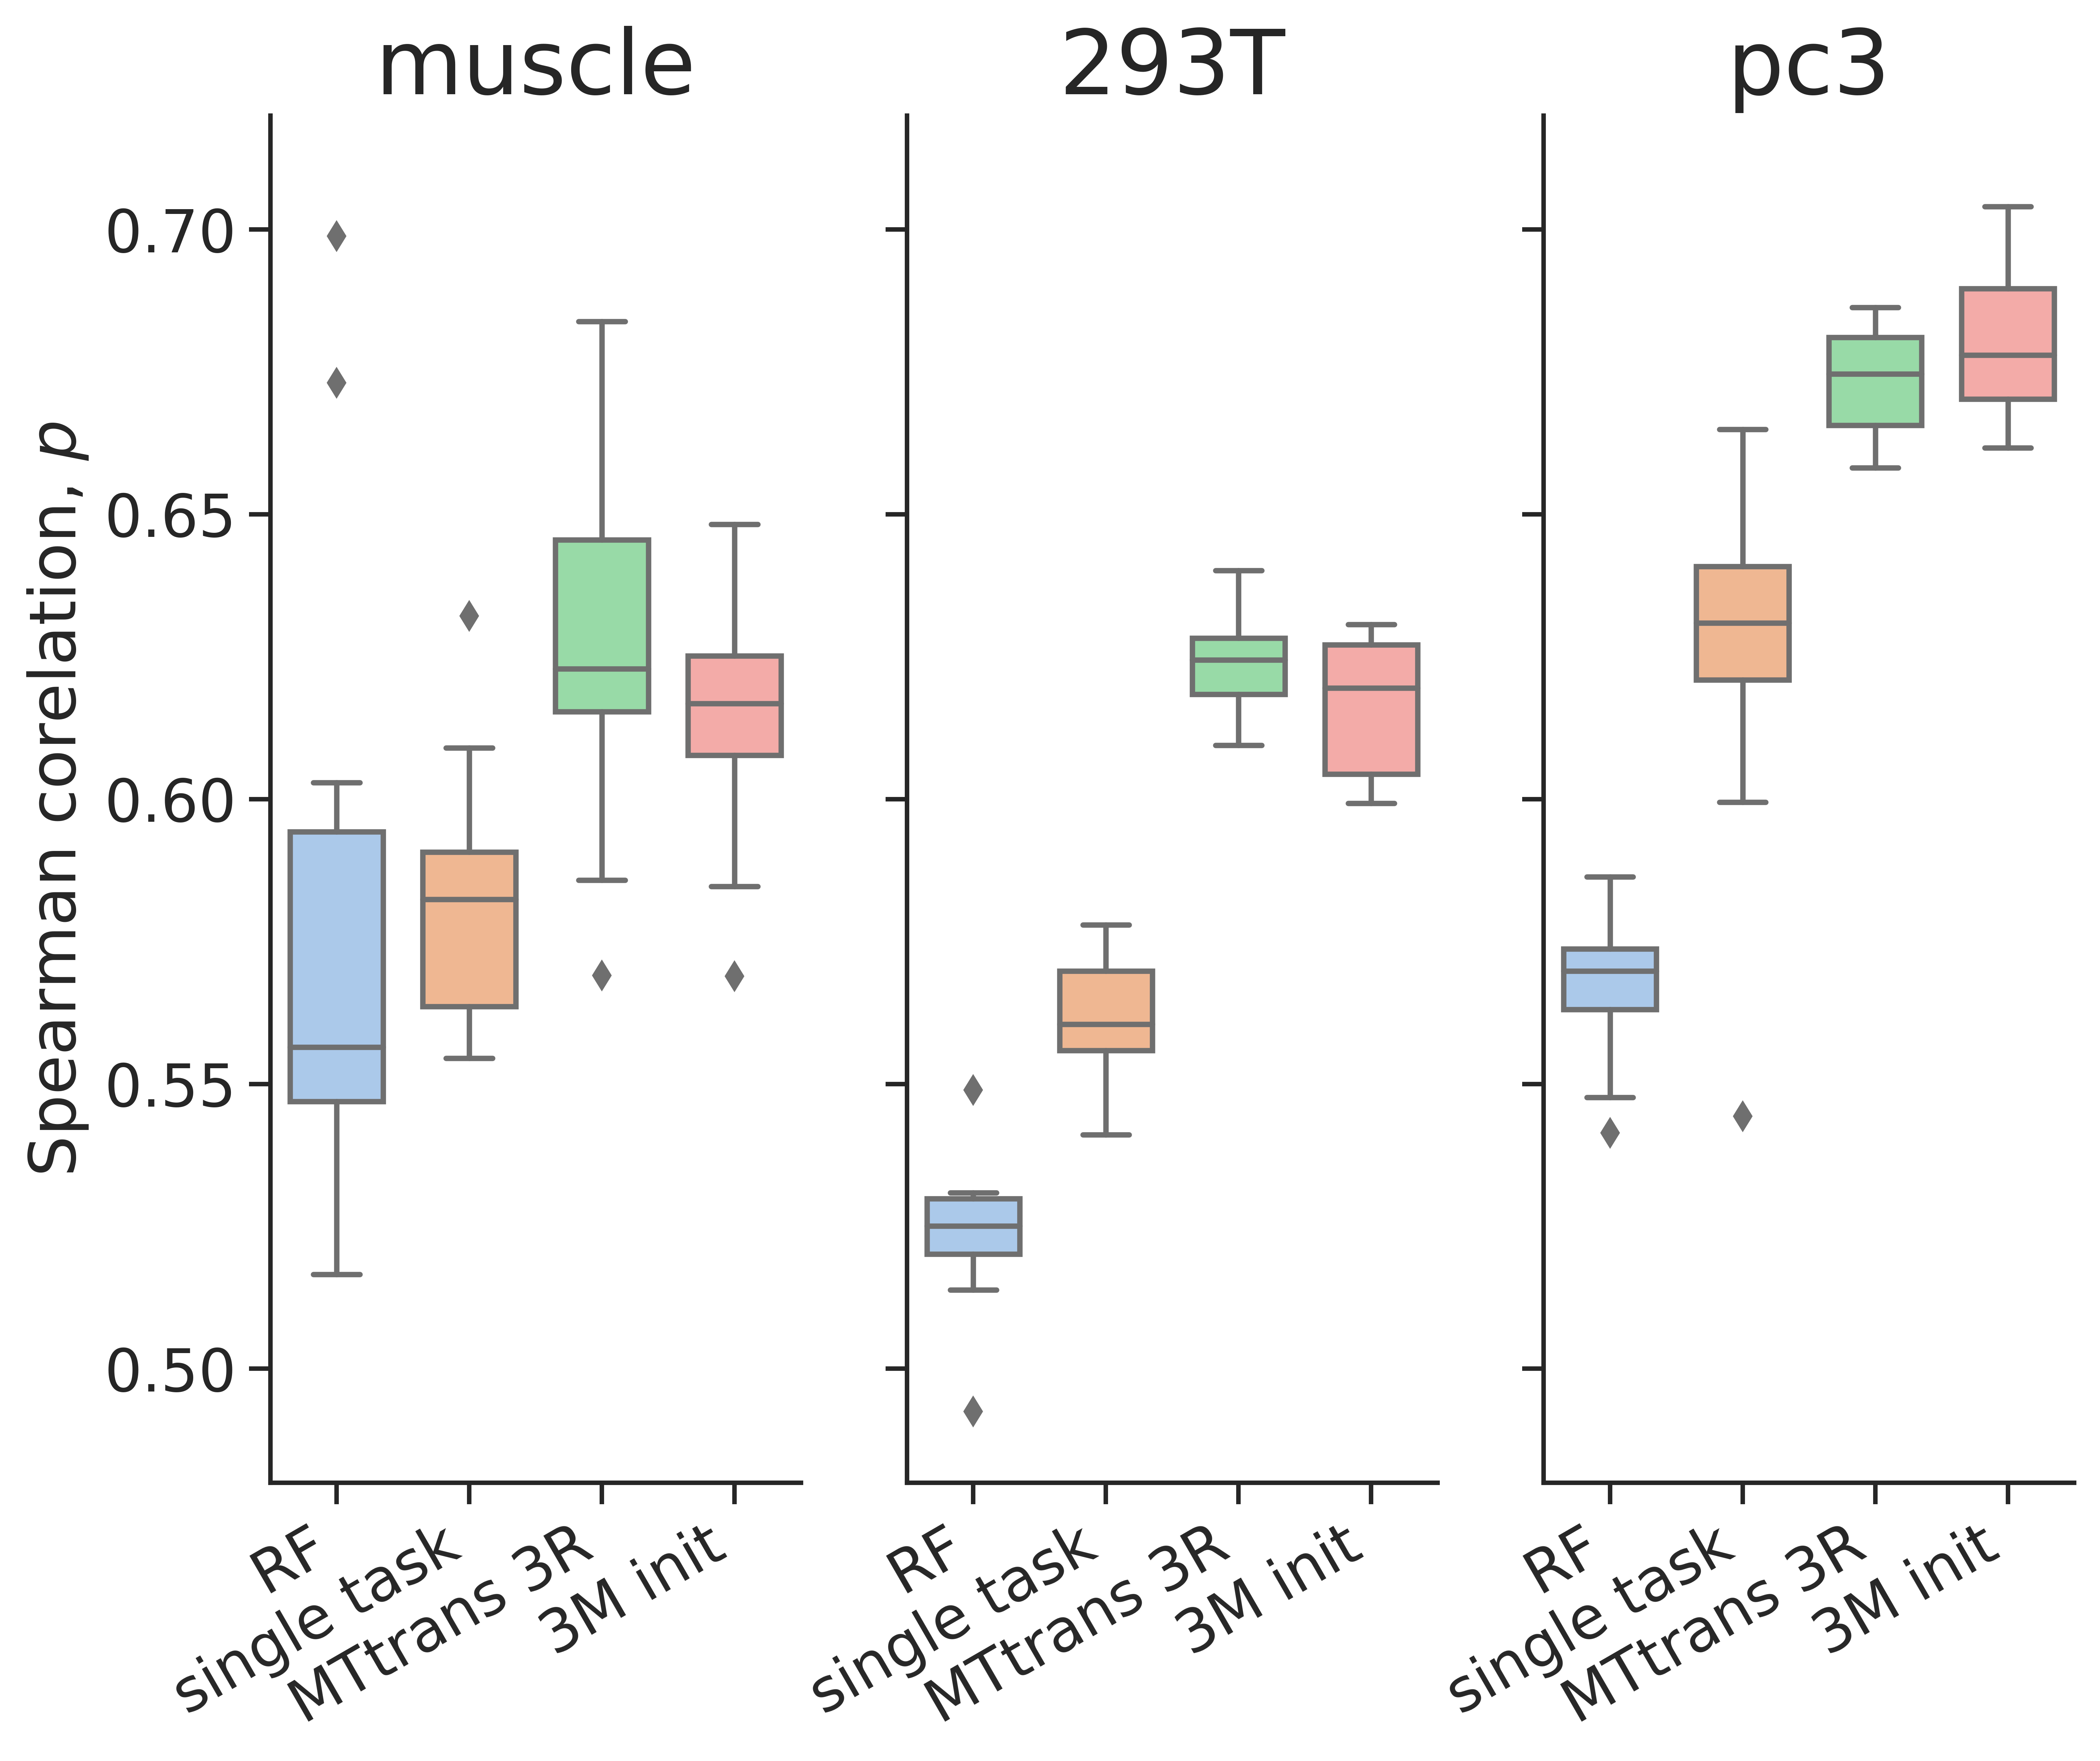

In [54]:
fig, axs = plt.subplots(1,3, figsize=(9,7), dpi=700, sharey=True)
for i, task in enumerate(tasks):
    
    axs[i].set_ylim(0.48, 0.72)
    cols = [col for col in celline_df.columns if task in col]
    sns.boxplot(data=celline_df[cols], ax=axs[i], width=0.7)
    sns.despine(offset=0.01, trim=False, ax=axs[i])
    
    axs[i].set_title(task.replace('Andrev2015','293T'),fontsize=25)
axs[0].set_xticklabels(labels=['RF', 'single task', 'MTtrans 3R', '3M init'], ha='right', rotation= 30)
axs[1].set_xticklabels(labels=['RF', 'single task', 'MTtrans 3R', '3M init'], ha='right', rotation= 30)
axs[2].set_xticklabels(labels=['RF', 'single task', 'MTtrans 3R', '3M init'], ha='right', rotation= 30)
    
axs[0].set_ylabel(r'Spearman corelation, $p$')

# supplementary 1 &2

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(9,7), dpi=700, sharey=True)


sns.boxplot(data=celline_df, ax=axs[i], width=0.7)
sns.despine(offset=0.01, trim=False, ax=axs[i])
    
axs[0].set_xticklabels(labels=['RF', 'single task', 'MTtrans 3R', '3M init'], ha='right', rotation= 30)
axs[1].set_xticklabels(labels=['RF', 'single task', 'MTtrans 3R', '3M init'], ha='right', rotation= 30)
axs[2].set_xticklabels(labels=['RF', 'single task', 'MTtrans 3R', '3M init'], ha='right', rotation= 30)
    
axs[0].set_ylabel(r'Spearman corelation, $p$')

In [359]:
transfer = [0.8915551918210738, 0.7824691144340565, 0.8558836449455097]

muscle = [0.779487,0.664968, 0.734561,0.743242, 0.674570, 0.667419,0.747756,0.683884,0.733356,0.711558]

HEK = [0.648189,0.660934,0.617841,0.648385,0.652521,0.618487,0.620484,0.653222,0.646648,0.653515]
pc3 = [0.681493,0.670005,0.683072,0.670842,0.701247,0.675444,0.699005,0.707599,0.689475,0.673914]

fil_w_na = lambda x : np.array(x+[np.nan]*7)

dup_data = pd.DataFrame({'transfer_Andrev':fil_w_na(transfer),'dup_Andrev':HEK, 'dup_muscle':muscle, 'dup_pc3':pc3 })

In [362]:
de_dup = pd.concat([celline_df[['Andrev2015','muscle','pc3']],dup_data],axis=1)

<AxesSubplot:>

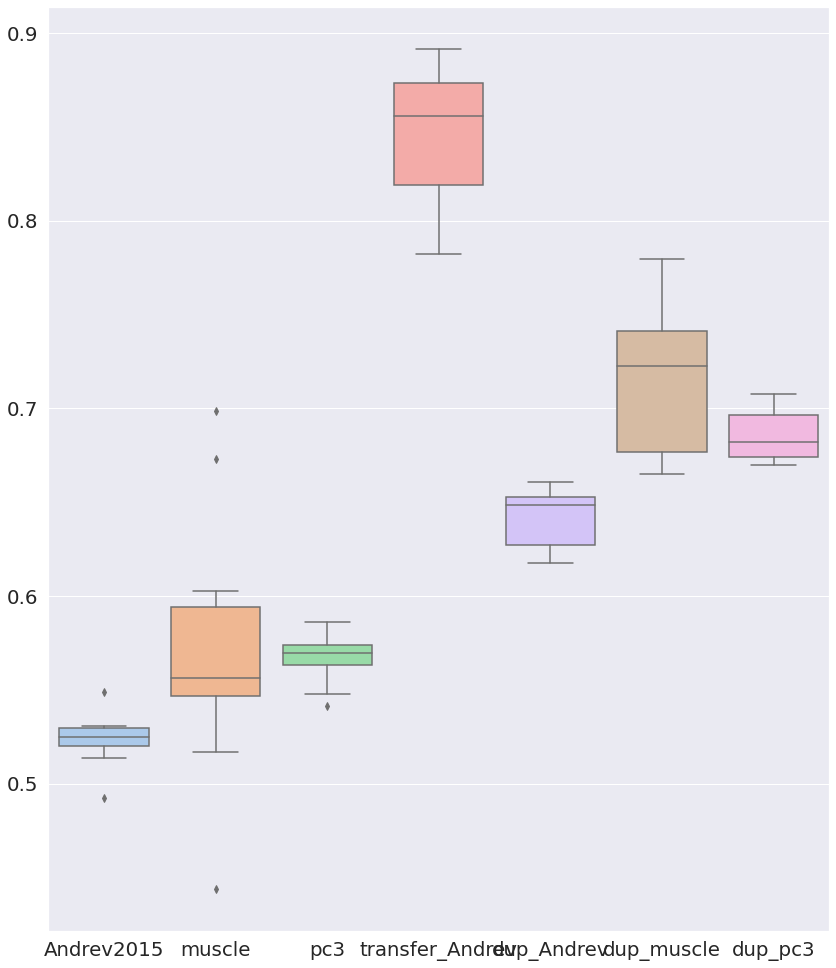

In [365]:
plt.figure(figsize=(14,17))
sns.boxplot(data=de_dup)

In [10]:
pretrain_relax = {task:[] for task in ['Andrev2015','muscle','pc3']}

for k in range(6):
    config_file = 'log/Backbone/RL_celline/MDL_pretrain_kfold/schedule.ini'
    dictt = pipeline_cell_line(config_file, which_set=2, device='cpu', kfold_index=k)
    for t, value in pretrain_relax.items():
        value.append(dictt[t])

fixed_data = pd.DataFrame(pretrain_relax).rename({'Andrev2015':"3M transfer_293T",'muscle':"3M transfer_muscle",'pc3':"3M transfer_pc3"},axis=1)

# Fig 3 B C

 293T cv=4  scratch

pc3 cv=8 pretrain

In [18]:
from Bio import SeqIO

In [24]:
# read the ensembl transcript reference file
ref_path = "/data/users/wergillius/UTR_VAE/5UTR_Optimizer/data/df_counts_and_len.TE_sorted.HEK_Andrev2015.with_annot.txt"

ref_txt = pd.read_table(ref_path,sep=' ').iloc[:,-4:-1]
# convert to. dict for easiler indexed by Transcript ID

In [20]:
def foward_out(config_file, which_set=2, device='cpu', kfold_index=None, expand_MAP=False, label_uAUG=False):
    
    device = torch.device('cuda:%s'%device) if type(device)==int else 'cpu'
    
    loader_set = kfold_load_data(config_file, device, kfold_index, label_uAUG=label_uAUG, expand_MAP=expand_MAP)
    
    # trained tasks from popen
    config_file = os.path.join("/ssd/users/wergillius/Project/UTR_VAE/", config_file)
    model = reload_model(config_file, device, kfold_index)
    popen = Auto_popen(config_file)
    trained_task = popen.cycle_set
    
    # iter tasks
    y_dict = {}
    df_dict = {}
    for cycle in list(loader_set.keys()):
        model.task = cycle # which works for normal RL_gru
        
        if expand_MAP:
            # use human tower to predict unmod1 or vleng
            if (cycle in ['vleng', 'unmod1']) and (model.task not in trained_task):
                model.task = 'human' if 'human'  in trained_task else 'SubHuman'
                
        dataloader = loader_set[cycle][which_set]
        df_dict[cycle] = dataloader.dataset.df
        y_dict[cycle] = val_a_epoch(model, dataloader, device)
    
    del model
    
    return y_dict, df_dict

In [21]:
config_file = 'log/Backbone/RL_celline/adam_MTL_log_te/adam_logte.ini'
out_293, df_293 = foward_out(config_file, which_set=2, device='cpu', kfold_index=4, label_uAUG=False)

100%|██████████| 108/108 [00:01<00:00, 99.85it/s] 


In [22]:
# annotate the df
df_293['Andrev2015'].loc[:,'predicted'] = out_293['Andrev2015'][1]

anno_293_df = df_293['Andrev2015'].merge(ref_txt, left_on=['T_id'], right_index=True)
# query transcripts with TE over-estimated
overestimated_df = anno_293_df.query('(-4.9 < `log_te` < -2.5)&(-1.8 < `predicted` <2.8)')

In [23]:
anno_293_df.iloc[0,2] in ref_dict['ENST00000394384'].seq

NameError: name 'ref_dict' is not defined

the Transcript IDs were pasted into this online converter to get the gene name  
https://biodbnet-abcc.ncifcrf.gov/db/db2db.php

In [25]:
from scipy.stats import gaussian_kde

In [26]:
x,y = out_293['Andrev2015']

In [27]:
# read the ensembl transcript reference file
ref_path = "/data/users/wergillius/UTR_VAE/5UTR_Optimizer/data/df_counts_and_len.TE_sorted.pc3.with_annot.txt"

ref_txt = pd.read_table(ref_path,sep=' ').iloc[:,-4:-1]

In [29]:
config_file = 'log/Backbone/RL_celline/MDL_pretrain_relax/pretrain_relax.ini'
out_pc3, df_pc3 = foward_out(config_file, which_set=2, device='cpu', kfold_index=8)

100%|██████████| 108/108 [00:16<00:00,  6.47it/s]


In [30]:
df_pc3['pc3'].loc[:,'predicted'] = out_pc3['pc3'][1]
anno_pc3 = df_pc3['pc3'].merge(ref_txt, left_on=['T_id'],right_index=True)
# (-3.8,-1.7), 1.8,  2.2
overestimated_pc3 = anno_pc3.query('(-3.8 < `log_te` < -2)&(-1.7 < `predicted` < 0.5)')

In [31]:
for T in (overestimated_pc3.T_id.values):
    print(T.split('.')[0])

ENST00000489595
ENST00000375094
ENST00000292524
ENST00000561457
ENST00000362074
ENST00000546139
ENST00000372009
ENST00000407653
ENST00000531243
ENST00000592292
ENST00000543580
ENST00000395067
ENST00000555076
ENST00000380283
ENST00000432842
ENST00000597157
ENST00000381112
ENST00000339497
ENST00000561069
ENST00000217381
ENST00000494478
ENST00000586891
ENST00000423685
ENST00000283628
ENST00000455319
ENST00000491381
ENST00000378536
ENST00000556563
ENST00000409379
ENST00000391865
ENST00000418635
ENST00000527302
ENST00000492838
ENST00000252999
ENST00000329970
ENST00000599686
ENST00000538431


In [32]:
def plot_density_scatter(x,y, ax=None, **kwargs):
    xy = np.vstack([x,y])
    Z = gaussian_kde(xy)(xy)

    sns.set_theme(style='ticks', font_scale=1.1)
    if ax==None:
        ax = plt.subplots(1,1, figsize=(4,4),dpi=700)
        # ax.plot([xmin,xmax],[xmin,xmax], '--', color='black', alpha=0.3)

    scatter1 = ax.scatter(x, y, c=Z,  cmap='twilight', **kwargs)

    sns.despine(ax=ax, trim=False)
    return ax

In [33]:
from matplotlib.patches import Rectangle

In [34]:
Rectangle

matplotlib.patches.Rectangle

In [35]:
Rectangle((-4.2,-2), 2, 3)

Text(-1, -3.9, '$\\rho=0.640$')

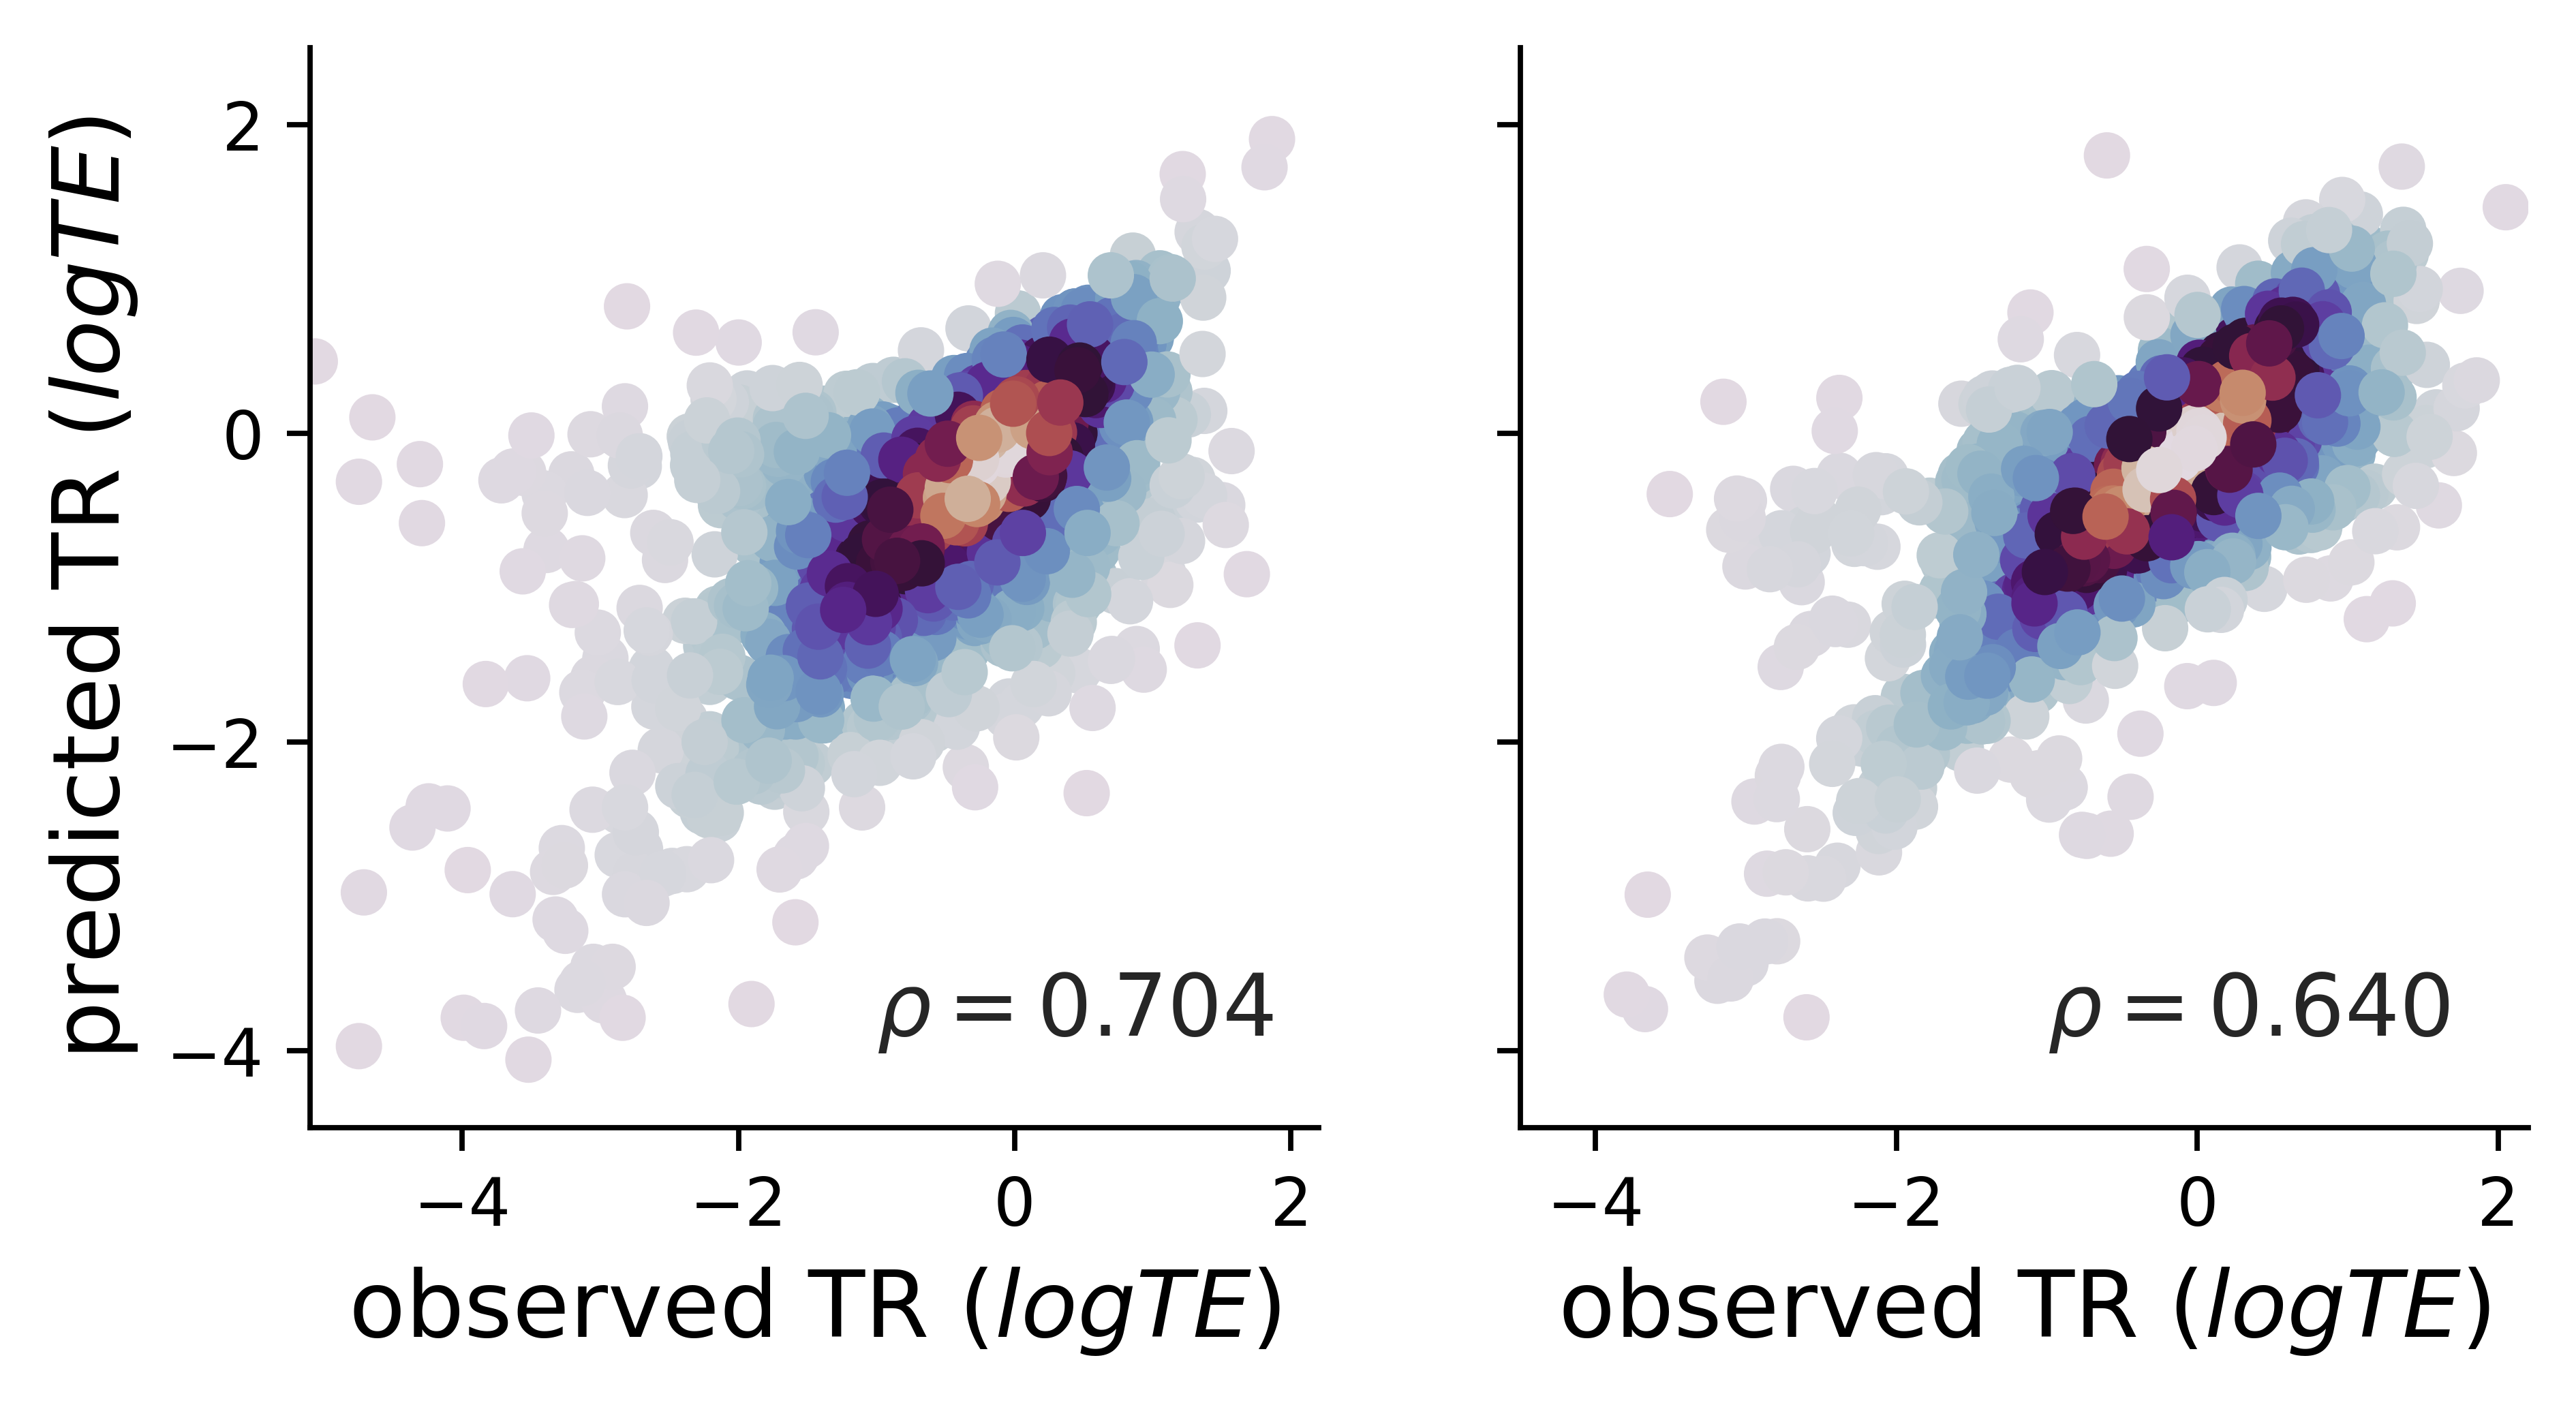

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,3), sharey=True, dpi=700)
ax1 = plot_density_scatter(*out_293['Andrev2015'], ax1)
ax2 = plot_density_scatter(*out_pc3['pc3'], ax2)

ax1.set_ylabel(r'predicted TR ($log TE$)', fontsize=14)
ax1.text(-1,-3.9, r"$\rho=0.704$", fontsize=13)

# 
# rec1 = Rectangle((-4.9,-1.8), 2.4, 3, fill=False, edgecolor = 'gray', ls= "--", lw=1.3)
# ax1.add_patch(rec1)

#
# rec2 = Rectangle((-3.8,-1.7), 1.8,  2.2, fill=False, edgecolor = 'gray', ls= "--", lw=1.4)
# ax2.add_patch(rec2)

ax1.set_ylim(-4.5, 2.5);
ax1.set_yticks([-4,-2,0,2]);
for ax in [ax1, ax2]:
    ax.set_xlabel(r'observed TR ($log TE$)', fontsize=14);
ax1.set_xlim(-5.1,2.2)
ax1.set_xticks([-4,-2,0,2]);

ax2.set_xlim(-4.5, 2.2)
ax2.set_xticks([-4,-2,0,2]);
ax2.text(-1,-3.9, r"$\rho=0.640$", fontsize=13)

In [45]:
C3 = pd.read_csv('FIG3_3cellline_permformance.csv')

In [65]:
C3

NameError: name 'C3' is not defined

In [47]:
C3_df = pd.DataFrame([])
for column in ['scratch_Andrev2015', 'scratch_muscle', 'scratch_pc3']:
    tmp = C3[[column]].copy().rename({column:'spr'}, axis=1)
    tmp['task'] = column
    
    C3_df = C3_df.append(tmp)
C3_df['model'] = 'RL_3_cell'
C3_df['R2'] = C3_df['spr'].values**2

In [61]:
C3_df['task'] = C3_df['task'].apply(lambda x: x.replace('scratch_', ''))

In [49]:
SubHuman_3C = []
config_file = 'log/Backbone/RL_6_data/1M3C/SubHuman_3C_1.ini'
for i in range(4):
    SubHuman_3C.append(pipeline_cell_line(config_file, which_set=2, device = 1, kfold_index=i, expand_MAP=True))

SubHuman_3C_data = testset_result(SubHuman_3C, 'SubHuman_3C')

NameError: name 'pipeline_cell_line' is not defined

In [14]:
print(SubHuman_3C_data.task.unique())
SubHuman_3C_data.head(4)

['SubHuman' 'Andrev2015' 'vleng' 'pc3' 'muscle' 'unmod1']


,task,sp_r,model,R2
0,SubHuman,0.821,SubHuman_3C,0.674041
1,Andrev2015,0.627,SubHuman_3C,0.393129
2,vleng,0.721,SubHuman_3C,0.519841
3,pc3,0.689,SubHuman_3C,0.474721


## s s